In [24]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


In [27]:
races = {
    "Sakhir": 0, "Jeddah": 1, "Melbourne": 2, "Imola": 3, "Miami": 4,
    "Barcelona": 5, "Monaco": 6, "Baku": 7, "Montréal": 8, "Silverstone": 9,
    "Spielberg": 10, "Le Castellet": 11, "Budapest": 12, "Spa-Francorchamps": 13,
    "Zandvoort": 14, "Monza": 15, "Marina Bay": 16, "Suzuka": 17, "Austin": 18,
    "Mexico City": 19, "São Paulo": 20, "Yas Island": 21, "Portimão": 22,
    "Montmeló": 23, "Monte-Carlo": 24, "Spa": 13, "Sochi": 26, "Istanbul": 27,
    "Al Daayen": 28, "Abu Dhabi": 30, "Spain": 31, "Mugello": 32, "Nürburg": 33,
    "Shanghai": 34, "Hockenheim": 35, "Montreal": 36, "Spielberg0": 37,
    "Spielberg1": 38, 'Silverstone2': 39, 'Silverstone3': 40, "Sakhir4": 41, 
    "Sakhir5": 42
}


In [29]:
compound = {
    "SOFT": 0,
    "MEDIUM": 1,
    "HARD": 2,
    "INTERMEDIATE": 3,
    "WET": 4
}


In [2]:
df = pd.read_csv('C:/Users/User/Desktop/Capstone Project/dataset1.csv')

In [3]:
df.head()

,Race,Year,Lap,Air Temperature,Humidity,Pressure,Rainfall,Track Temperature,Wind Direction,Wind Speed,DriverNumber,Compound_Encoded
0,2,2019,0,23.7,70.3,1015.4,0,43.6,176,1.4,10,0.0
1,2,2019,1,23.6,70.1,1015.3,0,43.3,191,1.3,10,0.0
2,2,2019,2,23.5,70.5,1015.4,0,43.4,68,1.3,10,0.0
3,2,2019,3,23.7,69.1,1015.3,0,43.4,328,1.8,10,0.0
4,2,2019,4,23.7,69.1,1015.4,0,43.0,149,1.2,10,0.0


In [4]:
df = df.drop('Year', axis=1)

Random Forest

In [42]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Reverse mapping for race and compound names
reverse_race_encoding = {v: k for k, v in races.items()}  # Reverse map race encoding
reverse_compound_encoding = {v: k for k, v in compound.items()}  # Reverse map compound encoding

# Drop 'Compound_Encoded' column to use as target (y)
X = df.drop('Compound_Encoded', axis=1)
y = df['Compound_Encoded']

# One-Hot Encode the categorical features
X_encoded = pd.get_dummies(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Build the Random Forest model with specified hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=21,           # Maximum depth of each tree
    min_samples_split=3,    # Minimum number of samples required to split an internal node
    min_samples_leaf=1,     # Minimum number of samples required at a leaf node
    random_state=42         # Random seed for reproducibility
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")

# Map the encoded race numbers back to race names
X_test['Race_Name'] = X_test['Race'].map(reverse_race_encoding)

# Map the predicted 'Compound_Encoded' values back to tyre compound names
y_pred_compound = pd.Series(y_pred).map(reverse_compound_encoding)

# Function to test the model with custom input values
def test_model_with_input(race_name, driver_number, lap_time, air_temp, humidity, pressure, rainfall, track_temp, wind_dir, wind_speed):
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'Race': [race_name],
        'DriverNumber': [driver_number],
        'Lap': [lap_time],
        'Air Temperature': [air_temp],
        'Humidity': [humidity],
        'Pressure': [pressure],
        'Rainfall': [rainfall],
        'Track Temperature': [track_temp],
        'Wind Direction': [wind_dir],
        'Wind Speed': [wind_speed]
    })

    # One-hot encode the input data
    input_data_encoded = pd.get_dummies(input_data)
    
    # Ensure input data has the same columns as the training data
    input_data_encoded = input_data_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Predict the compound using the trained model
    prediction_encoded = rf_model.predict(input_data_encoded)
    
    # Map the encoded prediction back to the actual compound name
    predicted_compound = reverse_compound_encoding[prediction_encoded[0]]
    
    return predicted_compound

# Example of user-defined inputs for testing
custom_race = 2  # Corresponding race ID (example)
custom_driver_number = 44
custom_lap_time = 5
custom_air_temp = 23.6
custom_humidity = 69.0
custom_pressure = 1015.4
custom_rainfall = 0
custom_track_temp = 42.9
custom_wind_dir = 150
custom_wind_speed = 1.2

# Call the function and print the predicted compound
predicted_tyre = test_model_with_input(custom_race, custom_driver_number, custom_lap_time, custom_air_temp, custom_humidity, custom_pressure, custom_rainfall, custom_track_temp, custom_wind_dir, custom_wind_speed)
print(f"Predicted Tyre Compound: {predicted_tyre}")


Random Forest Accuracy: 0.8535286284953395
Predicted Tyre Compound: SOFT


In [40]:
import pickle

# Assuming your model is stored in a variable called 'model'
with open('model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)


CatBoost

In [8]:
# Build CatBoost model
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = cat_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"CatBoost Accuracy: {accuracy}")


CatBoost Accuracy: 0.8255659121171771


XGBoost

In [9]:
X = df.drop('Compound_Encoded', axis=1)
y = df['Compound_Encoded']

# One-Hot Encode categorical features
X_encoded = pd.get_dummies(X)

# Convert target labels to integers using LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Convert data into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': len(le.classes_),  # Number of classes in target
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train XGBoost model with multi-class objective
bst = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)

# Make predictions
y_pred = bst.predict(dtest)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy}")


c:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8135818908122503


c:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


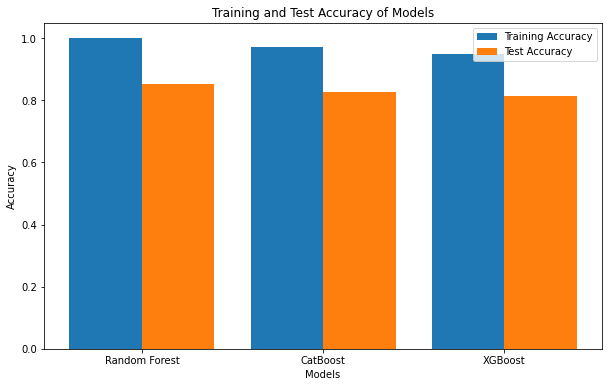

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize a dictionary to store the results
results = {}

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Random Forest Predictions and Accuracy
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)
rf_train_accuracy = accuracy_score(y_train, y_pred_train_rf)
rf_test_accuracy = accuracy_score(y_test, y_pred_test_rf)

# Store Random Forest results
results['Random Forest'] = {
    'train_accuracy': rf_train_accuracy,
    'test_accuracy': rf_test_accuracy
}

# CatBoost Model
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

# CatBoost Predictions and Accuracy
y_pred_train_cat = cat_model.predict(X_train)
y_pred_test_cat = cat_model.predict(X_test)
cat_train_accuracy = accuracy_score(y_train, y_pred_train_cat)
cat_test_accuracy = accuracy_score(y_test, y_pred_test_cat)

# Store CatBoost results
results['CatBoost'] = {
    'train_accuracy': cat_train_accuracy,
    'test_accuracy': cat_test_accuracy
}

# XGBoost Model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': len(le.classes_),
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

bst = xgb.train(params, dtrain, num_boost_round=100)

# XGBoost Predictions and Accuracy
y_pred_train_xgb = bst.predict(dtrain)
y_pred_test_xgb = bst.predict(dtest)
xgb_train_accuracy = accuracy_score(y_train, y_pred_train_xgb)
xgb_test_accuracy = accuracy_score(y_test, y_pred_test_xgb)

# Store XGBoost results
results['XGBoost'] = {
    'train_accuracy': xgb_train_accuracy,
    'test_accuracy': xgb_test_accuracy
}

# Plot the results
labels = list(results.keys())
train_accuracies = [results[model]['train_accuracy'] for model in labels]
test_accuracies = [results[model]['test_accuracy'] for model in labels]

x = range(len(labels))

plt.figure(figsize=(10, 6))

# Plot train accuracy
plt.bar(x, train_accuracies, width=0.4, label='Training Accuracy', align='center')

# Plot test accuracy
plt.bar([i + 0.4 for i in x], test_accuracies, width=0.4, label='Test Accuracy', align='center')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy of Models')
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()

# Display the plot
plt.show()


c:\Users\User\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


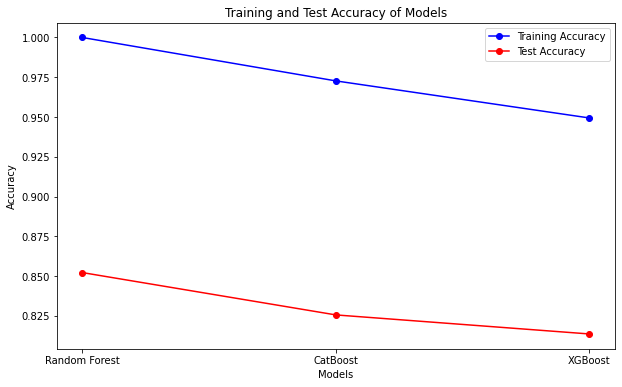

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize a dictionary to store the results
results = {}

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Random Forest Predictions and Accuracy
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)
rf_train_accuracy = accuracy_score(y_train, y_pred_train_rf)
rf_test_accuracy = accuracy_score(y_test, y_pred_test_rf)

# Store Random Forest results
results['Random Forest'] = {
    'train_accuracy': rf_train_accuracy,
    'test_accuracy': rf_test_accuracy
}

# CatBoost Model
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

# CatBoost Predictions and Accuracy
y_pred_train_cat = cat_model.predict(X_train)
y_pred_test_cat = cat_model.predict(X_test)
cat_train_accuracy = accuracy_score(y_train, y_pred_train_cat)
cat_test_accuracy = accuracy_score(y_test, y_pred_test_cat)

# Store CatBoost results
results['CatBoost'] = {
    'train_accuracy': cat_train_accuracy,
    'test_accuracy': cat_test_accuracy
}

# XGBoost Model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': len(le.classes_),
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

bst = xgb.train(params, dtrain, num_boost_round=100)

# XGBoost Predictions and Accuracy
y_pred_train_xgb = bst.predict(dtrain)
y_pred_test_xgb = bst.predict(dtest)
xgb_train_accuracy = accuracy_score(y_train, y_pred_train_xgb)
xgb_test_accuracy = accuracy_score(y_test, y_pred_test_xgb)

# Store XGBoost results
results['XGBoost'] = {
    'train_accuracy': xgb_train_accuracy,
    'test_accuracy': xgb_test_accuracy
}

# Plot the results
labels = list(results.keys())
train_accuracies = [results[model]['train_accuracy'] for model in labels]
test_accuracies = [results[model]['test_accuracy'] for model in labels]

x = range(len(labels))

plt.figure(figsize=(10, 6))

# Plot train accuracy line
plt.plot(x, train_accuracies, marker='o', linestyle='-', color='blue', label='Training Accuracy')

# Plot test accuracy line
plt.plot(x, test_accuracies, marker='o', linestyle='-', color='red', label='Test Accuracy')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy of Models')
plt.xticks(x, labels)
plt.legend()

# Display the plot
plt.show()


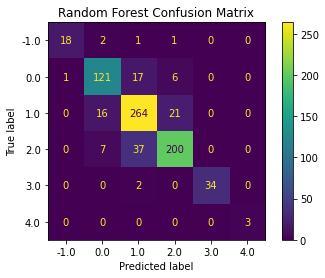

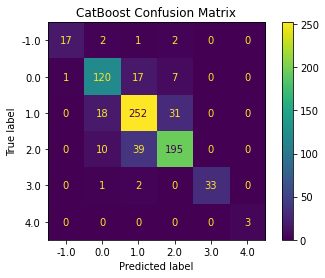

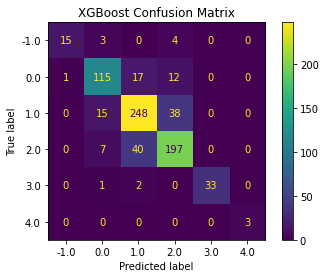

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, y_pred_test_rf)
ConfusionMatrixDisplay(rf_cm, display_labels=le.classes_).plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

# Confusion Matrix for CatBoost
cat_cm = confusion_matrix(y_test, y_pred_test_cat)
ConfusionMatrixDisplay(cat_cm, display_labels=le.classes_).plot()
plt.title('CatBoost Confusion Matrix')
plt.show()

# Confusion Matrix for XGBoost
xgb_cm = confusion_matrix(y_test, y_pred_test_xgb)
ConfusionMatrixDisplay(xgb_cm, display_labels=le.classes_).plot()
plt.title('XGBoost Confusion Matrix')
plt.show()


In [16]:
# Ensure target_names are strings
target_names = [str(cls) for cls in le.classes_]

# Classification report for Random Forest
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_test_rf, target_names=target_names))

# Classification report for CatBoost
print("\nCatBoost Classification Report")
print(classification_report(y_test, y_pred_test_cat, target_names=target_names))

# Classification report for XGBoost
print("\nXGBoost Classification Report")
print(classification_report(y_test, y_pred_test_xgb, target_names=target_names))



Random Forest Classification Report
              precision    recall  f1-score   support

        -1.0       0.95      0.82      0.88        22
         0.0       0.83      0.83      0.83       145
         1.0       0.82      0.88      0.85       301
         2.0       0.88      0.82      0.85       244
         3.0       1.00      0.94      0.97        36
         4.0       1.00      1.00      1.00         3

    accuracy                           0.85       751
   macro avg       0.91      0.88      0.90       751
weighted avg       0.85      0.85      0.85       751


CatBoost Classification Report
              precision    recall  f1-score   support

        -1.0       0.94      0.77      0.85        22
         0.0       0.79      0.83      0.81       145
         1.0       0.81      0.84      0.82       301
         2.0       0.83      0.80      0.81       244
         3.0       1.00      0.92      0.96        36
         4.0       1.00      1.00      1.00         3

    accur

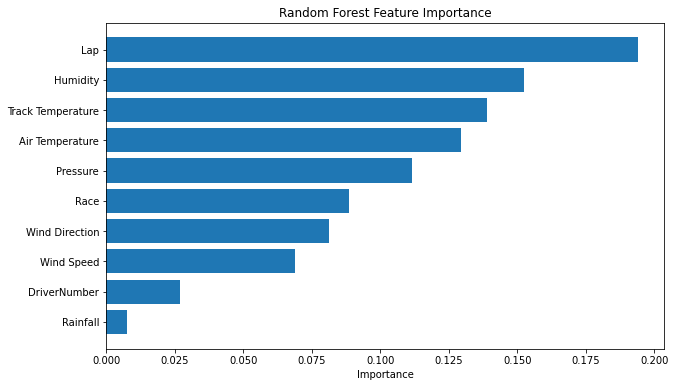

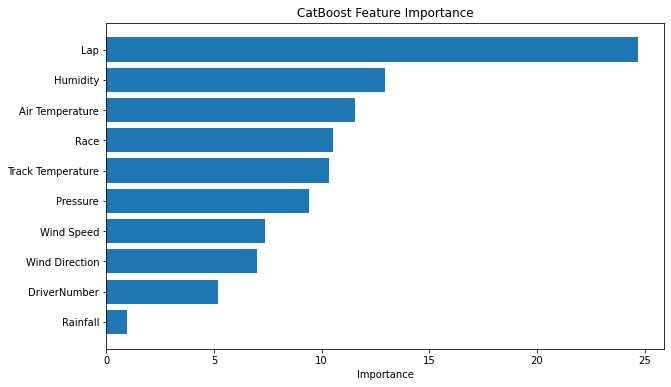

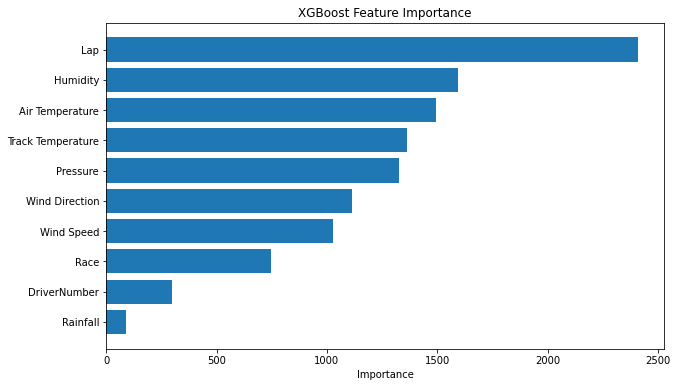

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Random Forest Feature Importance
rf_feature_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance_df['Feature'], rf_feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To display the most important at the top
plt.show()

# 2. CatBoost Feature Importance
cat_feature_importance = cat_model.get_feature_importance()

# Create a DataFrame for CatBoost feature importance
cat_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cat_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for CatBoost
plt.figure(figsize=(10, 6))
plt.barh(cat_feature_importance_df['Feature'], cat_feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # To display the most important at the top
plt.show()

# 3. XGBoost Feature Importance
xgb_feature_importance = bst.get_score(importance_type='weight')

# Convert to DataFrame for easier plotting
xgb_feature_importance_df = pd.DataFrame({
    'Feature': list(xgb_feature_importance.keys()),
    'Importance': list(xgb_feature_importance.values())
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # To display the most important at the top
plt.show()


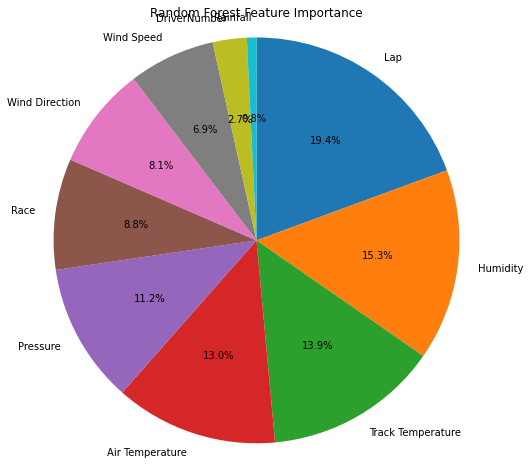

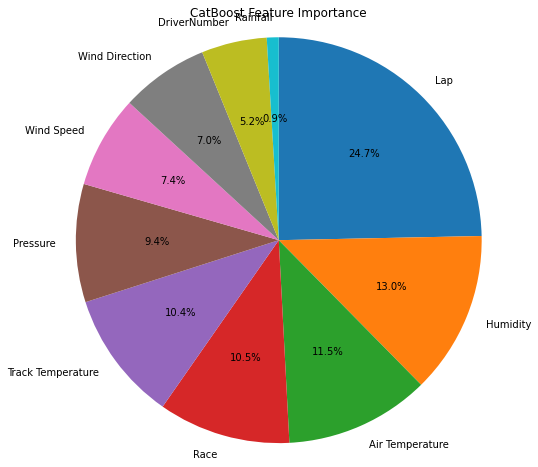

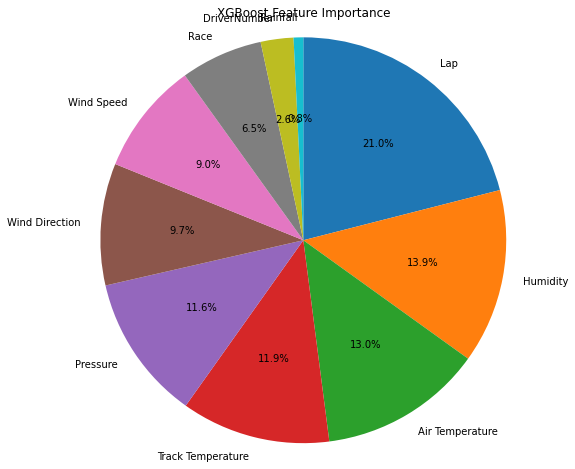

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Helper function to plot pie chart
def plot_feature_importance_pie(feature_importance_df, model_name):
    plt.figure(figsize=(8, 8))
    plt.pie(feature_importance_df['Importance'], labels=feature_importance_df['Feature'],
            autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(f'{model_name} Feature Importance')
    plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle
    plt.show()

# 1. Random Forest Feature Importance
rf_feature_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for Random Forest as a pie chart
plot_feature_importance_pie(rf_feature_importance_df, 'Random Forest')

# 2. CatBoost Feature Importance
cat_feature_importance = cat_model.get_feature_importance()

# Create a DataFrame for CatBoost feature importance
cat_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cat_feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for CatBoost as a pie chart
plot_feature_importance_pie(cat_feature_importance_df, 'CatBoost')

# 3. XGBoost Feature Importance
xgb_feature_importance = bst.get_score(importance_type='weight')

# Convert to DataFrame for easier plotting
xgb_feature_importance_df = pd.DataFrame({
    'Feature': list(xgb_feature_importance.keys()),
    'Importance': list(xgb_feature_importance.values())
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for XGBoost as a pie chart
plot_feature_importance_pie(xgb_feature_importance_df, 'XGBoost')
